# Train AdaLiNe

In [ ]:
import matplotlib.pyplot as plt
from ch02_adaline import AdalineGD
import pandas as pd
import numpy as np

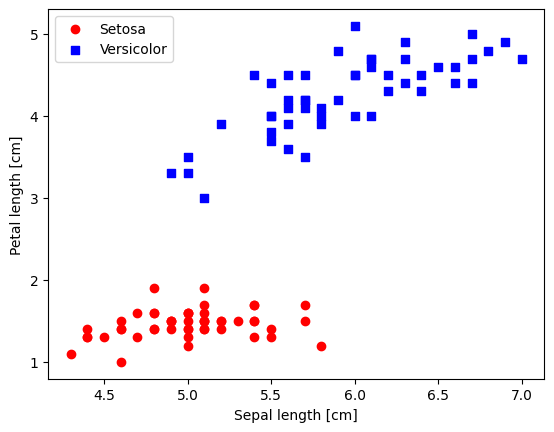

In [11]:
iris_url = 'https://archive.ics.uci.edu/ml/'\
    'machine-learning-databases/iris/iris.data'

iris_df = pd.read_csv(iris_url, header=None)

y = iris_df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

X = iris_df.iloc[0:100, [0,2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='s', label='Versicolor')

plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

## Aplicando el Modelo

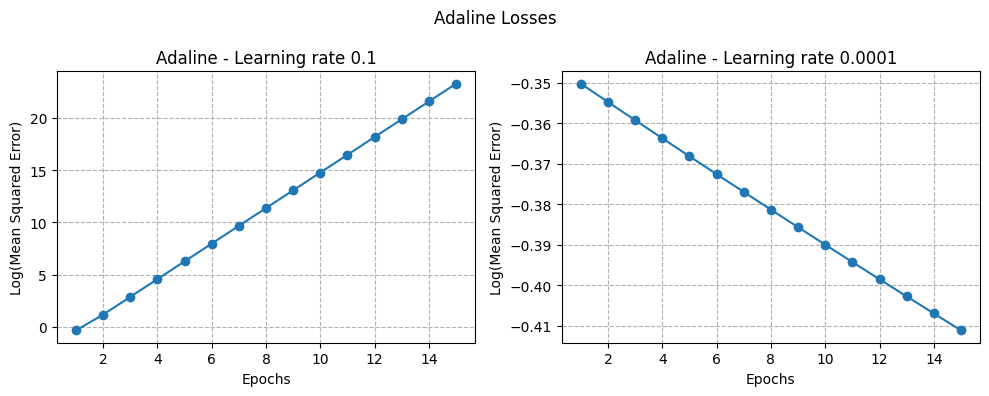

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

ada1 = AdalineGD(n_iter = 15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log(Mean Squared Error)')
ax[0].set_title('Adaline - Learning rate 0.1')
ax[0].grid(linestyle='--')

ada2 = AdalineGD(n_iter = 15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), np.log10(ada2.losses_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Log(Mean Squared Error)')
ax[1].set_title('Adaline - Learning rate 0.0001')
ax[1].grid(linestyle='--')

fig.suptitle('Adaline Losses')
plt.tight_layout()
plt.show()

### ¿Por qué se aplica `log10` a la pérdida en los gráficos?

Durante el entrenamiento del modelo, la función de pérdida (MSE) puede abarcar varios órdenes de magnitud, comenzando con valores grandes y disminuyendo rápidamente a valores muy pequeños.

Aplicar `np.log10()` a las pérdidas:

- **Comprime los valores grandes**
- **Expande los valores pequeños**
- **Facilita la visualización** de mejoras sutiles en etapas avanzadas del entrenamiento

Esto permite comparar mejor cómo evoluciona la pérdida a lo largo de las épocas, especialmente cuando se prueban distintas tasas de aprendizaje (`eta`).


---

As we can see in the resulting loss function plots, we encountered two different types of problems. The left chart shows what could happen if we choose a learning rate that is too large. Instead of minimizing the loss function, the MSE becomes larger in every epoch, because we **overshoot** the global minimum. On the other hand, we can see that the loss decreases on the right plot, but the chosen learning rate, **𝜂 = 0001**, is so small that the algorithm would require a very large number of epochs to converge to the global loss minimum.

The subfigure on the right, however, illustrates what happens if we choose a learning rate that is too large—we overshoot the global minimum:
![well eta choosen](images/eta-gd.png)


## Aplicando Estandarización al Gradiente de descenso

In [13]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:,0].mean()) / X[:,0].std()
X_std[:, 1] = (X[:, 1] - X[:,1].mean()) / X[:,1].std()

In [14]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

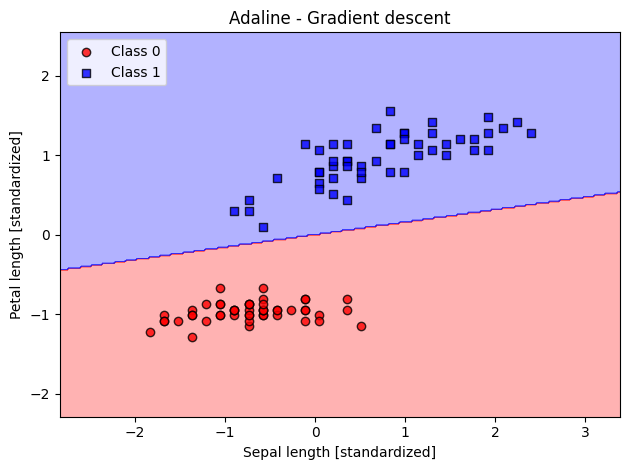

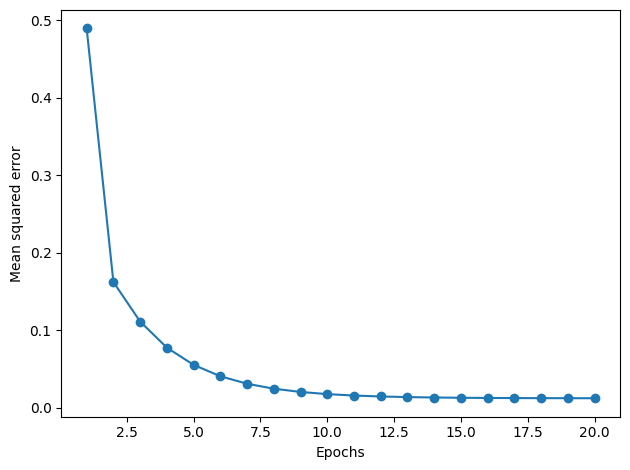

In [31]:
ada_gd = AdalineGD(n_iter = 20, eta=0.5)
ada_gd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/02_14_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')

plt.tight_layout()
#plt.savefig('images/02_14_2.png', dpi=300)
plt.show()

## Aplicando Gradiente de descenso Estocástico *(SGD)* con AdaLiNe

In [78]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X.ravel(), y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.default_rng(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [79]:
ada_sgd = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)
y_preds = ada_sgd.predict(X_std)
print(y_preds == y)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


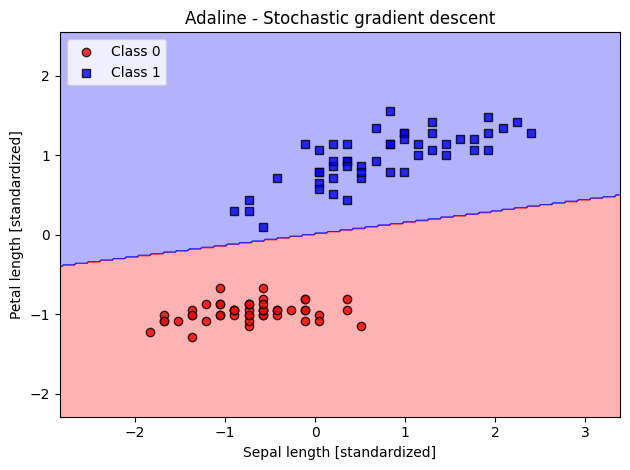

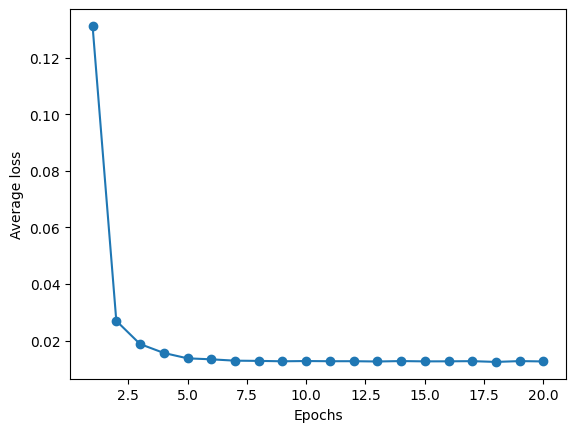

In [80]:
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')

plt.show()

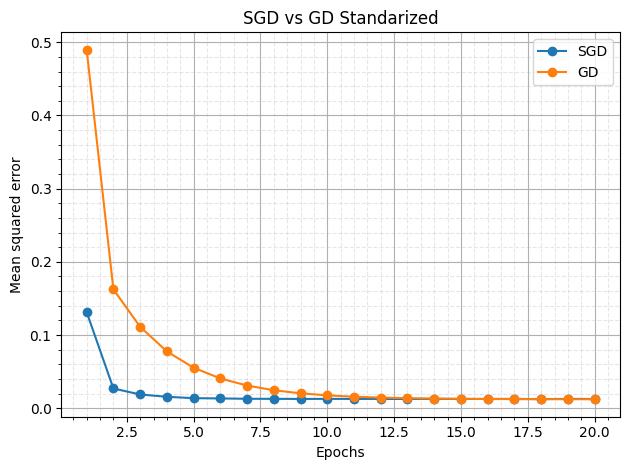

In [81]:
plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o', label='SGD')
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o',label='GD')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.title('SGD vs GD Standarized')

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle='--', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

In [82]:
print('Convergencia:\n', round(ada_sgd.losses_[-1],4), round(ada_gd.losses_[-1],4))

Convergencia:
 0.0126 0.0123


### SGD Online

In [83]:
X_new = X_std[[10]]
y_new = np.array([y[10]])

ada_sgd.partial_fit(X_new, y_new)

# Predicción en esa misma muestra después del update
print("Predicción tras partial_fit:", ada_sgd.predict(X_new))
print("Etiqueta real:", y_new)

Predicción tras partial_fit: [0]
Etiqueta real: [0]
